In [14]:
from IPython.display import HTML
HTML('''<script>
var code_show_err = false; 
var code_toggle_err = function() {
 var stderrNodes = document.querySelectorAll('[data-mime-type="application/vnd.jupyter.stderr"]')
 var stderr = Array.from(stderrNodes)
 if (code_show_err){
     stderr.forEach(ele => ele.style.display = 'block');
 } else {
     stderr.forEach(ele => ele.style.display = 'none');
 }
 code_show_err = !code_show_err
} 
document.addEventListener('DOMContentLoaded', code_toggle_err);
</script>
To toggle on/off warnings, click <a onclick="javascript:code_toggle_err()">here</a>.''')

## Preamble

In this notebook we'll look to do the following:
* Get TFL Station location data (point data).
* Get London borough shapefiles (polygon data)
* Plot the data on a map.
    * Try various visualisation options.
* Generate 1000 locations in London at random.
* Calculate the distance between those locations and their nearest station at scale, using `kdtrees`.
* Exploring the use of voronoi diagrams to acheive a similar result.

During the project we should cover the following.
* Loading location data into `geopandas`.
* Data Visualisation.
* Spatial Joins.
* Nearest neighbour calculations with `kdtrees`.
* Creating voronoi diagrams.

## Import packages

Firstly we'll import some necessary packages in order to get started.

* `Geopandas` is a Python package which allows us access to tabular datastructures with some very helpful geospatial methods. 
* `hvplot` is visulisation package which provides a pandas-like API and `bokeh`-like plotting, it also works well with geospatial visualisations via calls to the `geoviews` package.
* `pandas` for the creation of tabular data structures.

In [9]:
import geopandas as gp
import hvplot as hv
import hvplot.pandas
import numpy as np
import pandas as pd

In [6]:
pd.set_option('display.max_rows', 50)

## Data Gathering

Firstly, we'll get data in London for each TFL station.

In [3]:
import geopandas as gp
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

tfl_stations = gp.read_file('data/stations.kml', driver='KML')
tfl_stations.geometry = gp.points_from_xy(tfl_stations.geometry.x, tfl_stations.geometry.y)

Now we have a table of stations in London with their names, a brief description, and their geometries.

In [4]:
tfl_stations.head()

Name                                        Description  \
0    Acton Town Station  Acton Town Station, London Underground Ltd., G...   
1       Aldgate Station  Aldgate Station, London Underground Ltd., Aldg...   
2  Aldgate East Station  Aldgate East Station, London Underground Ltd.,...   
3      Alperton Station  Alperton Station, London Underground Ltd., Eal...   
4      Amersham Station  Amersham Station, Stn Approach, Amersham, Buck...   

                    geometry  
0  POINT (-0.28025 51.50275)  
1  POINT (-0.07561 51.51427)  
2  POINT (-0.07229 51.51523)  
3  POINT (-0.29949 51.54069)  
4  POINT (-0.60748 51.67415)

Let's inspect the geometry co-ordinate reference system.

In [5]:
tfl_stations.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Data Visualisation

Let's plot the data ont to a map, along with the `Name` of the station in the hover tool. <br>
We're using an `x` marker to differentiate them from the other points we'll be plotting.

In [10]:
tfl_stations_plot = tfl_stations.hvplot(geo=True,
                                        title='TFL Stations',
                                        marker='x',
                                        color='red',
                                        size=20,
                                        tiles='CartoLight', 
                                        hover_cols=["Name"]
                                       )
tfl_stations_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Name)

Now we'll get locations of some other places in London, we'll be generating 1000 points at random.

To do this, let's first get the total bounds of the polygon. <br>
We're doing so because we're only interested in random points within the total area all of the TFL stations cover. <br>
This will tell us the most `West`, `South`, `East` and `North` points respectively.

In [11]:
tfl_stations.total_bounds

array([-0.61121925, 51.40233694,  0.25108712, 51.70503045])

Now let's convert that into a polygon to get the total area covered by all the TFL stations. <br>
We can do this by using `unary_union` to bring all the points together, followed by `convex_hull` to convert the set of points to a polygon.

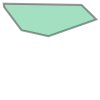

In [7]:
tfl_polygon = tfl_stations.unary_union.convex_hull
tfl_polygon

Now let's convert this Polygon to a `GeoDataFrame` by using the `GeoDataFrame` constructor.

In [13]:
area_df = gp.GeoDataFrame(
    pd.DataFrame([tfl_polygon], columns=['geometry']), 
    geometry='geometry', 
    crs=tfl_stations.crs)

We can now plot this below, I've set the transparancy to `0.1` so we can still see the tiles below.

In [14]:
area_df_plot = area_df.hvplot(geo=True, tiles='CartoLight', alpha = 0.1, c='yellow')
area_df_plot.opts(title='TFL Station footprint')

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Polygons.I :Polygons   [Longitude,Latitude]

We can also easily plot both the stations and the convex area on one plot by using the `*` operator.

However, we need to be sure that the tiles are only defined in one of the two plots, otherwise they'll overlap and we won't be able to see the stations.

We can do this by accessing the `.Polygons` attribute of the plot we just did above, this means the `.Tiles` element of the plot is ignored.

In [15]:
(tfl_stations_plot * area_df_plot.Polygons).opts(title='TFL Stations with their total footprint')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Name)
   .I.I      :Polygons   [Longitude,Latitude]

Next we'll get select 1000 random points within this polygon to calculate Neighest Neighbours. <br>
The function below: `random_point_in_shp` will select a random point within a polygon. <br>
This function was helpfully found [here](https://stackoverflow.com/questions/58802921/using-geopandas-how-to-randomly-select-in-each-polygon-5-points-by-sampling-met).

In [2]:
from shapely.geometry import Point
def random_point_in_shp(shp):
    within = False
    while not within:
        x = np.random.uniform(shp.bounds[0], shp.bounds[2])
        y = np.random.uniform(shp.bounds[1], shp.bounds[3])
        within = shp.contains(Point(x, y))
    return Point(x, y)

In [11]:
list_of_random_points = [random_point_in_shp(tfl_polygon) for num in range(1000)]

Now we have a list of random points within the polygon, let's turn this into a `GeoDataFrame` and plot along with the other objects.

In [12]:
random_points_in_ldn = gp.GeoDataFrame(list_of_random_points, columns=['geometry'])
random_points_in_ldn.crs = "EPSG:4326"
random_points_in_ldn.name = 'Random Points in London'

Let's have a look at some of these random points.

In [13]:
random_points_in_ldn.head()

geometry
0   POINT (0.10997 51.55762)
1  POINT (-0.04711 51.64586)
2   POINT (0.06053 51.51326)
3  POINT (-0.52292 51.64782)
4  POINT (-0.27685 51.44340)

## Spatial Join

So now we have the following dataframes:
* `tfl_stations`
* `area_df`
* `random_points_in_ldn`

But let's say we want to find out which area each random point is in. <br>
Fear not, we're not going to do this by hand. <br>
Instead we'll do a spatial join, where we'll take:
1. A shapefile with the boundaries of all areas in the UK
1. The random points 

We'll do a spatial join between the points and the boundaries, this will tell us which boundary each point is within.

First let's get boundary data for the UK at a Local Authority District level. <br>
Luckily, geopandas allows us to read in data from the internet directly, we simply need to supply the correct url, which we can get from the [ONS Geography](https://geoportal.statistics.gov.uk/datasets/local-authority-districts-december-2019-boundaries-uk-bfe-1/geoservice) website, which is a brilliant resource for UK Geospatial data.

In [20]:
lad_url = 'https://opendata.arcgis.com/datasets/a8531598f29f44e7ad455abb6bf59c60_0.geojson'
lad_shapes = gp.read_file(lad_url, geometry='geometry')

In [21]:
lad_shapes.head()

FID  objectid    lad19cd               lad19nm lad19nmw   bng_e   bng_n  \
0    1         1  E06000001            Hartlepool           447160  531474   
1    2         2  E06000002         Middlesbrough           451141  516887   
2    3         3  E06000003  Redcar and Cleveland           464361  519597   
3    4         4  E06000004      Stockton-on-Tees           444940  518183   
4    5         5  E06000005            Darlington           428029  515648   

      long        lat    st_areasha     st_lengths   Shape__Area  \
0 -1.27018  54.676140  9.834667e+07   66121.472650  2.936180e+08   
1 -1.21099  54.544670  5.455359e+07   41055.809886  1.618700e+08   
2 -1.00608  54.567520  2.537854e+08  105292.138896  7.533942e+08   
3 -1.30664  54.556911  2.097308e+08  108085.255484  6.229205e+08   
4 -1.56835  54.535339  1.974757e+08  107206.401677  5.861353e+08   

   Shape__Length                                           geometry  
0  114237.019030  POLYGON ((-1.26846 54.72612, -1.26822 54.72609...  
1   70707.553942  POLYGON ((-1.25112 54.59153, -1.24953 54.59151...  
2  181407.418071  POLYGON ((-1.14105 54.64773, -1.13798 54.64737...  
3  186270.209578  POLYGON ((-1.31729 54.64480, -1.31715 54.64480...  
4  184666.724479  POLYGON ((-1.63768 54.61714, -1.63767 54.61670...

Let's plot these shapes to see what this looks like.

In [22]:
lad_shapes_plot = lad_shapes.hvplot(geo=True, alpha = 0.3,  crs=lad_shapes.crs.to_json(), hover_cols=['lad19nm'])

Let's look at `lad_shapes`, notice the `lad19nm` which has the name of the area and the `geometry` column which has the the Polygon objects.

In [23]:
random_points_in_ldn.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
lad_shapes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now we'll do the spatial join, just like any other join we declare the two objects we're joining together: `random_points_in_ldn` and `lad_shapes`, we then state the `how`, and we also state `op="within"` to show we want the join to occur when one point is within the boundary.

In [25]:
random_points_in_ldn_lad = gp.sjoin(random_points_in_ldn, lad_shapes, how="left", op='within')

Let's look at this new dataframe, we should see that for each random point in london that we created we see the associated area in the `lad19nm` column.

In [26]:
random_points_in_ldn_lad.head()

geometry  index_right  FID  objectid    lad19cd  \
0   POINT (0.17591 51.56014)          285  286       286  E09000002   
1  POINT (-0.29055 51.46466)          310  311       311  E09000027   
2  POINT (-0.37521 51.59626)          298  299       299  E09000015   
3  POINT (-0.48303 51.56366)           58   59        59  E07000006   
4   POINT (0.07565 51.55831)          309  310       310  E09000026   

                lad19nm lad19nmw   bng_e   bng_n      long        lat  \
0  Barking and Dagenham           547757  185111  0.129479  51.545551   
1  Richmond upon Thames           519005  172650 -0.289140  51.440350   
2                Harrow           515356  189736 -0.336030  51.594669   
3           South Bucks           498198  185455 -0.584840  51.559441   
4             Redbridge           543511  189478  0.070071  51.585892   

     st_areasha    st_lengths   Shape__Area  Shape__Length  
0  3.779933e+07  36967.152758  9.760414e+07   59416.338108  
1  5.876117e+07  52354.149660  1.510920e+08   83956.367244  
2  5.046331e+07  33735.460700  1.306423e+08   54276.073344  
3  1.412756e+08  85473.909916  3.651027e+08  137404.373222  
4  5.644221e+07  45768.737333  1.460110e+08   73624.240673

Let's add a simple deccription column for each random point. <br>
For each row, this column will say:
* what area the random point was in
* the random point rank in that area i.e. Random point 1, 2, 3 etc.

We'll put this together with a list comprehension and an f-string.

In [27]:
random_point_number = random_points_in_ldn_lad.groupby('lad19nm')['objectid'].transform(lambda x: x.rank(method='first')).astype(str)

random_points_in_ldn_lad['random_point_desc'] = \
[f"Random point in {random_points_in_ldn_lad['lad19nm'].loc[index]}: {random_point_number.loc[index]}" 
 for index, row in random_points_in_ldn_lad.iterrows()] 

Let's sort the dataframe and have a look at it, including the `random_point_desc` column at the end.

In [28]:
random_points_in_ldn_lad = random_points_in_ldn_lad.sort_values(['lad19nm', 'random_point_desc'])
random_points_in_ldn_lad

geometry  index_right  FID  objectid    lad19cd  \
0     POINT (0.17591 51.56014)          285  286       286  E09000002   
270   POINT (0.12841 51.58233)          285  286       286  E09000002   
291   POINT (0.13864 51.51966)          285  286       286  E09000002   
337   POINT (0.14616 51.55141)          285  286       286  E09000002   
339   POINT (0.12109 51.52358)          285  286       286  E09000002   
..                         ...          ...  ...       ...        ...   
277  POINT (-0.18770 51.53031)          316  317       317  E09000033   
347  POINT (-0.13561 51.49024)          316  317       317  E09000033   
438  POINT (-0.12347 51.49438)          316  317       317  E09000033   
473  POINT (-0.13068 51.50522)          316  317       317  E09000033   
544  POINT (-0.16833 51.52701)          316  317       317  E09000033   

                  lad19nm lad19nmw   bng_e   bng_n      long        lat  \
0    Barking and Dagenham           547757  185111  0.129479  51.545551   
270  Barking and Dagenham           547757  185111  0.129479  51.545551   
291  Barking and Dagenham           547757  185111  0.129479  51.545551   
337  Barking and Dagenham           547757  185111  0.129479  51.545551   
339  Barking and Dagenham           547757  185111  0.129479  51.545551   
..                    ...      ...     ...     ...       ...        ...   
277           Westminster           528268  180870 -0.152950  51.512199   
347           Westminster           528268  180870 -0.152950  51.512199   
438           Westminster           528268  180870 -0.152950  51.512199   
473           Westminster           528268  180870 -0.152950  51.512199   
544           Westminster           528268  180870 -0.152950  51.512199   

       st_areasha    st_lengths   Shape__Area  Shape__Length  \
0    3.779933e+07  36967.152758  9.760414e+07   59416.338108   
270  3.779933e+07  36967.152758  9.760414e+07   59416.338108   
291  3.779933e+07  36967.152758  9.760414e+07   59416.338108   
337  3.779933e+07  36967.152758  9.760414e+07   59416.338108   
339  3.779933e+07  36967.152758  9.760414e+07   59416.338108   
..            ...           ...           ...            ...   
277  2.203005e+07  27156.262444  5.681777e+07   43618.645318   
347  2.203005e+07  27156.262444  5.681777e+07   43618.645318   
438  2.203005e+07  27156.262444  5.681777e+07   43618.645318   
473  2.203005e+07  27156.262444  5.681777e+07   43618.645318   
544  2.203005e+07  27156.262444  5.681777e+07   43618.645318   

                            random_point_desc  
0     Random point in Barking and Dagenham: 1  
270  Random point in Barking and Dagenham: 10  
291  Random point in Barking and Dagenham: 11  
337  Random point in Barking and Dagenham: 12  
339  Random point in Barking and Dagenham: 13  
..                                        ...  
277            Random point in Westminster: 5  
347            Random point in Westminster: 6  
438            Random point in Westminster: 7  
473            Random point in Westminster: 8  
544            Random point in Westminster: 9  

[1000 rows x 16 columns]

## Section Recap

Let's plot everything we've done, to recap we now have data for the following:
* `tfl_stations` in London and Greater London. 
    * Plotted above as `tfl_stations_plot`.
* `area_df` - the convex hull of the area captured by these tfl_stations.
    * Plotted above as `area_df_plot`.
* `lad_shapes` - Shapefiles for the whole of the UK at Local Authority District level.
    * Plotted above as `lad_shapes_plot`.
* `random_points_in_ldn_lad` - 1000 random points in London we've generated, along with the area each point is in.
    * We'll plot this as `random_points_in_ldn_lad_plot` below.
    
As we're only concerned with London for this analysis, I'll filter the `lad_shapes` to only cover areas with a random point inside them, to create `ldn_lad_shapes`.

In [29]:
random_points_in_ldn_lad.head()

geometry  index_right  FID  objectid    lad19cd  \
0    POINT (0.17591 51.56014)          285  286       286  E09000002   
270  POINT (0.12841 51.58233)          285  286       286  E09000002   
291  POINT (0.13864 51.51966)          285  286       286  E09000002   
337  POINT (0.14616 51.55141)          285  286       286  E09000002   
339  POINT (0.12109 51.52358)          285  286       286  E09000002   

                  lad19nm lad19nmw   bng_e   bng_n      long        lat  \
0    Barking and Dagenham           547757  185111  0.129479  51.545551   
270  Barking and Dagenham           547757  185111  0.129479  51.545551   
291  Barking and Dagenham           547757  185111  0.129479  51.545551   
337  Barking and Dagenham           547757  185111  0.129479  51.545551   
339  Barking and Dagenham           547757  185111  0.129479  51.545551   

       st_areasha    st_lengths   Shape__Area  Shape__Length  \
0    3.779933e+07  36967.152758  9.760414e+07   59416.338108   
270  3.779933e+07  36967.152758  9.760414e+07   59416.338108   
291  3.779933e+07  36967.152758  9.760414e+07   59416.338108   
337  3.779933e+07  36967.152758  9.760414e+07   59416.338108   
339  3.779933e+07  36967.152758  9.760414e+07   59416.338108   

                            random_point_desc  
0     Random point in Barking and Dagenham: 1  
270  Random point in Barking and Dagenham: 10  
291  Random point in Barking and Dagenham: 11  
337  Random point in Barking and Dagenham: 12  
339  Random point in Barking and Dagenham: 13

In [30]:
ldn_lad_shapes = lad_shapes[lad_shapes['lad19cd'].isin(random_points_in_ldn_lad['lad19cd'].unique())]

In [31]:
ldn_lad_shapes = ldn_lad_shapes.to_crs(epsg=27700)

In [32]:
ldn_lad_shapes.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [33]:
ldn_lad_shapes_plot = ldn_lad_shapes.hvplot(
    crs = 'EPSG: 27700',
    alpha=0.3,
    hover_cols=['lad19nm'],
    cmap='glasbey_dark')

In [34]:
random_points_in_ldn_lad_plot = random_points_in_ldn_lad.hvplot(geo=True, s=3, hover_cols = ['random_point_desc'])

In [35]:
ldn_lad_shapes.head()

FID  objectid    lad19cd        lad19nm lad19nmw   bng_e   bng_n  \
57    58        58  E07000005       Chiltern           495432  198692   
58    59        59  E07000006    South Bucks           498198  185455   
98    99        99  E07000072  Epping Forest           548919  203758   
121  122       122  E07000095     Broxbourne           534742  204251   
122  123       123  E07000096        Dacorum           500084  208745   

         long        lat    st_areasha     st_lengths   Shape__Area  \
57  -0.621120  51.678902  1.963482e+08   87262.677913  5.102100e+08   
58  -0.584840  51.559441  1.412756e+08   85473.909916  3.651027e+08   
98   0.154147  51.712791  3.389841e+08  123273.197785  8.816642e+08   
121 -0.050730  51.720798  5.144230e+07   39068.745794  1.339057e+08   
122 -0.550980  51.768452  2.124764e+08  110103.830872  5.544747e+08   

     Shape__Length                                           geometry  
57   140675.161791  POLYGON ((491748.711 208468.099, 491775.211 20...  
58   137404.373222  POLYGON ((494609.112 193735.806, 494624.712 19...  
98   198858.939454  POLYGON ((549942.616 215785.905, 549968.110 21...  
121   63047.986118  POLYGON ((537127.516 210970.204, 537127.714 21...  
122  177905.152945  POLYGON ((505599.713 218260.807, 505619.212 21...

Let's plot all the artefacts we've created thus far on a single plot. <br>
We would normally split this much information out with mutliple plots with a shared axis, but I'd like to show that plot aggregation is possible and intuitive.

In [36]:
big_plot = tfl_stations_plot * ldn_lad_shapes_plot * area_df_plot.Polygons * random_points_in_ldn_lad_plot
(big_plot).opts(
    frame_width= 900,
    frame_height= 1000,
    title_format='Various geospatial artefacts',
    xlim=(-20000, -17000),
    ylim=(6650000, 6800000)
)


:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Points.I   :Points   [Longitude,Latitude]   (Name)
   .Polygons.I :Polygons   [Longitude,Latitude]   (lad19nm)
   .I.I        :Polygons   [Longitude,Latitude]
   .Points.II  :Points   [Longitude,Latitude]   (random_point_desc)

## Nearest Neighbours

You may be thinking, why did we create 1000 random points earlier, well now all is to be revealed.

Let's say we want to find the nearest tube station to everyone one of those 1000 random points. <br>
How would we do it? <br>
Remember, we have 1000 random points, and 302 stations. <br>
We could probably do a nested for loop...<br>
where, for each random point: we calculate its distance to each of the 302 stations, and then select the station with the smallest distance.

Now, whilst that might work, this approach requires `1000 x 302 == 302,000` distance calculations. <br>
It'll take some time, and how will it scale if we increase the number of points, to 10,000, or maybe a million. <br>
The answer is, not very well. 

This algorithm can be said to scale in time complexity with n<sup>2</sup>. <br>
The following section will show, that by storing our geospatial data in a binary search tree, rather than an array, we can speed up this process dramatically, such that time complexity scaled with the following relationship $O(D·N·logN)$.

Firstly, we'll change the co-ordinate reference system of our points so they are on a rectilinear geography. <br>
The algorithm we'll be using operates with euclidean distance so we need a flat plane rather than a curved plane.

This will require our data to be converted to a crs of``EPSG: 27700``, this is the rectilinear geometry for the UK.

In [37]:
tfl_stations = tfl_stations.to_crs(epsg = 27700)

In [38]:
random_points_in_ldn_lad = random_points_in_ldn_lad[['lad19nm', 'random_point_desc', 'geometry']].to_crs(epsg = 27700)

Below we'll create a function to help us calculate the nearest neighbours.

In [39]:
import numpy as np
from scipy.spatial import KDTree

In [40]:
def kdtreenearest(gdfA, gdfB):
    assert gdfA.crs.to_epsg() == gdfB.crs.to_epsg() == 27700, "Check crs."
    # Take a copy of both DataFrames
    gdfA, gdfB = gdfA.copy().reset_index(), gdfB.reset_index(drop=True)
    # Convert geometries to nested list of lists
    nA = np.array(list(zip(gdfA.geometry.x, gdfA.geometry.y)))
    nB = np.array(list(zip(gdfB.geometry.x, gdfB.geometry.y)))
    # Create kdtree object
    btree = KDTree(nB)
    # Query the tree for the nearest neigbour (k-1) with a euclidean geometry (p=2)
    dist, idx = btree.query(nA, k=1, p=2)
    # Create a list of data to concatenate, notice we ahd to reset_index the index above so the concanetation occurs on position
    # this is because when we converted our geometries to arrays, we lost row index information
    concat_list = [gdfA, 
                   gdfB.iloc[idx, :].loc[:, (gdfB.columns != 'geometry')].reset_index(drop=True),
                   pd.Series(dist, name='distance')]
    # Create the final dataframe, then add the original index of gdfA
    gdf = pd.concat(concat_list, axis=1, join='inner').set_index('index', drop=True)
    
    # Return a tuple of: the dataframe of interest, the list or raw distances, and the assocated indices of gdfB nearest neighbours
    return gdf, dist, idx

In [41]:
kdtree_results, raw_distances, idx = kdtreenearest(random_points_in_ldn_lad, tfl_stations)

That was quick!

Let's look at the results...

In [42]:
kdtree_results.head()

lad19nm                         random_point_desc  \
index                                                                   
0      Barking and Dagenham   Random point in Barking and Dagenham: 1   
270    Barking and Dagenham  Random point in Barking and Dagenham: 10   
291    Barking and Dagenham  Random point in Barking and Dagenham: 11   
337    Barking and Dagenham  Random point in Barking and Dagenham: 12   
339    Barking and Dagenham  Random point in Barking and Dagenham: 13   

                            geometry                       Name  \
index                                                             
0      POINT (550927.900 186827.091)      Dagenham East Station   
270    POINT (547563.803 189198.024)       Newbury Park Station   
291    POINT (548476.553 182250.395)          Becontree Station   
337    POINT (548894.180 185795.428)  Dagenham Heathway Station   
339    POINT (547245.877 182649.900)          Becontree Station   

                                             Description     distance  
index                                                                  
0      Dagenham East Station, London Underground Ltd....  1913.272188  
270    Newbury Park Station, London Underground Ltd.,...  2743.790074  
291    Becontree Station, London Underground Ltd., Ga...  2423.369040  
337    Dagenham Heathway Station, London Underground ...  1093.139587  
339    Becontree Station, London Underground Ltd., Ga...  1910.158476

The sample above looks to be correct, we can verify with the map we created earlier.

## Voronoi Diagrams

A Voronoi diagram is a way of partitioning a plane of points. <br>
For each point _p_ there is an associated voronoi region _R_ such that all points in R have _p_ as their closest point.

We can use voronoi diagrams to tesselate a space, this can help us answer the following question:
* For what region is Bank Station the closest possible station.

In the section above we did something similar with random points we created, with voronoi diagrams we can get straight to the region.

Let's import the necessary functions from `scipy.spatial`.

In [43]:
from scipy.spatial import Voronoi, voronoi_plot_2d

Let's convert the TFL station geometries into a nested list so `scipy` can understand them. <br>
**Remember**: These geometries must be rectilinear.

In [44]:
nA = np.array(list(zip(tfl_stations.geometry.x, tfl_stations.geometry.y))) 

This is what `tfl_stations` looks like.

In [45]:
tfl_stations.head()

Name                                        Description  \
0    Acton Town Station  Acton Town Station, London Underground Ltd., G...   
1       Aldgate Station  Aldgate Station, London Underground Ltd., Aldg...   
2  Aldgate East Station  Aldgate East Station, London Underground Ltd.,...   
3      Alperton Station  Alperton Station, London Underground Ltd., Eal...   
4      Amersham Station  Amersham Station, Stn Approach, Amersham, Buck...   

                        geometry  
0  POINT (519459.853 179603.230)  
1  POINT (533628.279 181237.984)  
2  POINT (533856.302 181350.995)  
3  POINT (518026.758 183791.694)  
4  POINT (496385.697 198181.627)

Let's construct the voronoi diagram with the `Voronoi` class.

In [46]:
tfl_vor = Voronoi(nA)

Now let's plot the regions with a simple matplotlib plot.

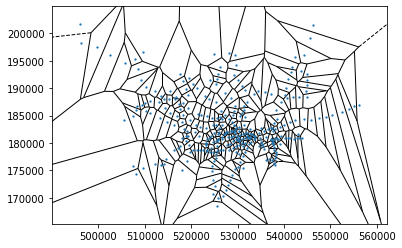

In [47]:
tfl_vor_simple_plot = voronoi_plot_2d(tfl_vor, show_vertices=False, point_size=2.5)

All looks good, but let's see if we can plot it interactively with `hvplot` just as we did earlier.

Each Voronoi object contains an attribute called `.ridge_vertices` which contains ["Indices of the Voronoi vertices forming each Voronoi ridge."](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.spatial.Voronoi.html)

We can use these in to create a nested list (`lines`) in which each outer list contains all the lines associated with one voroni ridge.

In [48]:
import shapely
lines = \
[shapely.geometry.LineString(tfl_vor.vertices[line])for line in tfl_vor.ridge_vertices if -1 not in line]

Now we can create polygons for each voronoi region.

In [49]:
shapely_voronoi_polygons = shapely.ops.polygonize(lines)

Now we can create a `GeoDataFrame` of these voronoi polygons.

In [50]:
voronoi_polygons = gp.GeoDataFrame(shapely_voronoi_polygons, geometry = 'geometry', columns=['geometry'], crs="EPSG:27700")
voronoi_polygons.head()

geometry
0  POLYGON ((538612.983 202297.832, 556085.003 19...
1  POLYGON ((536038.156 203989.737, 538612.983 20...
2  POLYGON ((521201.665 255848.165, 523271.165 24...
3  POLYGON ((523271.165 247654.059, 533759.623 21...
4  POLYGON ((533759.623 210866.549, 536038.156 20...

Now we can do a spatial join between the stations and the voronoi polygons so we can associate each voronoi polygon with its station.

In [51]:
tfl_voronoi = gp.sjoin(tfl_stations[['Name', 'geometry']], voronoi_polygons, how='right', op='within').drop(columns=['index_left'])

Now let's create a plot for the voronoi regions.

In [52]:
tfl_voronoi_plot = tfl_voronoi.hvplot(
    geo=True,
    crs='EPSG: 27700',
    alpha=0.1
)

In [53]:
(tfl_stations_plot * tfl_voronoi_plot)\
.opts(frame_height=500,
      frame_width=800,
      title_format='TFL stations and their voronoi regions',
    xlim=(-20000, -17000),
    ylim=(6650000, 6800000)
)

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Points.I   :Points   [Longitude,Latitude]   (Name)
   .Polygons.I :Polygons   [Longitude,Latitude]

As you can see above we have a problem... <br>
The algorithm behind the voronoi regions can sometimes lead to boundaries stretching to infinity. <br>
So from what we've learnt above, what's the common sense thing to do? <br>
Let's try and clip the voronoi regions, such at they cannot _grow_ past the convex hull of all TFL stations. This should stop Lewisham from expanding half way across the world!

First we'll copy the dataframe above.

In [54]:
tfl_voronoi_clipped = tfl_voronoi.copy().set_geometry('geometry')
tfl_polygon_df = gp.GeoDataFrame(pd.Series(tfl_polygon, name='geometry'), crs="EPSG:4326").to_crs('EPSG:27700')


Next we'll use the geopandas `overlay` function to clip the voronoi polyons, notice the `how='intersection'`.

In [55]:
tfl_voronoi_clipped = gp.overlay(tfl_voronoi_clipped, tfl_polygon_df, how='intersection')

In [56]:
tfl_voronoi_clipped_plot = tfl_voronoi_clipped.hvplot(
    geo=True,
    crs='EPSG: 27700',
    alpha=0.1
)

Now let's plot the results.

In [57]:
(tfl_stations_plot * tfl_voronoi_clipped_plot)\
.opts(frame_height=500,
      frame_width=800,
      title_format='TFL stations and their clipped voronoi regions',
    xlim=(-20000, -17000),
    ylim=(6650000, 6800000)
)

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Points.I   :Points   [Longitude,Latitude]   (Name)
   .Polygons.I :Polygons   [Longitude,Latitude]

So now we've clipped the voronoi regions to the convex hull of the stations.

This is a way to deal with the edge voronoi regions bounding to infinity, as was the case in Lewisham.

Finally, we'll compare the area of each voronoi region.

In [58]:
tfl_voronoi_clipped['Area (m²)'] = tfl_voronoi_clipped.geometry.area

In [59]:
tfl_voronoi_clipped[['Name', 'Area (m²)']].sort_values('Area (m²)').iloc[0:15,]\
.hvplot(title = "TFL Stations with the smallest voronoi regions", kind ='bar', geo=False, x="Name", y="Area (m²)",  rot=60)

:Bars   [Name]   (Area (m²))

In [60]:
tfl_voronoi_clipped[['Name', 'Area (m²)']].sort_values('Area (m²)').iloc[-15:,]\
.hvplot(title = "TFL Stations with the largest voronoi regions", kind ='bar', geo=False, x="Name", y="Area (m²)",  rot=60)

:Bars   [Name]   (Area (m²))

As we'd expect, central London stations are more tightly packed in, leading to smaller regions. Remote stattions such has Watford have larger regions.

## Challenge

If you'd like a challenge of your own, see if you can find the median voronoi region area per London borough and plot it as a bar chart below! <br>
As an extra challenge, see if you can repeat the analysis, including National Rail station locations.

There we have it, we've plotted voronoi diagrams, explored kdtrees, looked at geopandas for geospatial transformations, and done some interactive mapping visualisations. <br>
I've left some useful links below.

### Useful Links
* [Geopandas](https://geopandas.org/)
* [hvplot - Geographic Data](https://hvplot.holoviz.org/user_guide/Geographic_Data.html)
* [shapely](https://shapely.readthedocs.io/en/latest/manual.html)